In [1]:
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Reading Data Files**

In [2]:
building_meta_df =  pd.read_csv("buildings.csv")
building_info_df = pd.read_csv("building_info.csv")
building_price_history_df = pd.read_csv("building_pricing_history.csv")
building_unit_df = pd.read_csv("building_unit_data.csv")

**Merging building_meta_df, building_info_df and building_unit_df**

In [3]:
merged_df = pd.merge(building_meta_df, building_info_df, left_on='id', right_on='id', how='left')
merged_df.rename(columns={'id': 'building_id'}, inplace=True)
merged_df = pd.merge(merged_df, building_unit_df, left_on='building_id', right_on='building_id', how='inner')

**Extracting Chicago data**

In [4]:
chicago_df = merged_df[merged_df.city == "Chicago"]
chicago_df = chicago_df.reset_index()

In [5]:
chicago_df.shape

(55490, 78)

**Dropping columns with more than 60% missing values**

In [6]:
chicago_df['nearest_public_transportation'].isna().sum()

39914

In [7]:
chicago_df['nearest_convenience_store'].isna().sum()

39248

In [8]:
chicago_df['nearest_grocery_store'].isna().sum()

39296

In [9]:
to_drop = ['address',
           'amenities',
           'aptamigo',
           'architect',
           'available_date',
           'balcony',
           'city',
           'company',
           'company_id',
           'concession_additional',
           'concession_months_additional',
           'cooperation_percentage',
           'concession_source',
           'concession_title',
           'concession_update',
           'created_at',
           'created_on',
           'data_source',
           'description',
           'email',
           'floor',
           'flooring',
           'floorplan',
           'hotspot',
           'hotspot_description',
           'hotspot_features',
           'hotspot_neighbourhood',
           'leasing_type',
           'name',
           'nearest_convenience_store',
           'nearest_grocery_store',
           'nearest_public_transportation',
           'neighborhood_area',
           'no_of_units',
           'pet_policy',
           'phone',
           'price_change',
           'scrape_id',
           'scraped_on',
           'scraper_complete',
           'state',
           'summary',
           'type',
           'unit_convert_balcony',
           'unit_number',
           'updated_on',
           'website',
           'website_data_in_images',
           'website_needs_ui_navigation',
           'website_reachable',
           'zip'
          
          ]

In [10]:
chicago_df.drop(columns=to_drop, inplace=True)
chicago_df.shape

(55490, 27)

**Handling inconsistent data entries**

In [11]:
chicago_df = chicago_df.drop(chicago_df.loc[(chicago_df['price'] <= 100) | 
                                      (chicago_df['sqft'] == 0) | 
                                      (chicago_df['beds'] > 3) |
                                      (chicago_df['baths'] == 0)].index)

In [12]:
def map_baths(row):
    
    if row['beds'] == 0:
        return 1
        
    if row['baths'] > row['beds']:
        return int(row['beds'])
    
    return int(row['baths'])

In [13]:
chicago_df['baths'] = chicago_df.apply(map_baths, axis=1)

In [14]:
def map_bed(row):
    if row['beds'] == 0 and row['sqft'] > 615:
        return 1
    
    if row['beds'] == 1 and row['sqft'] < 494:
        return 0
    
    return int(row['beds'])

In [15]:
chicago_df['beds'] = chicago_df.apply(map_bed, axis=1)

In [16]:
chicago_df[['sqft', 'beds','baths']].groupby(['beds', 'baths']).describe()

sqft                                                           \
              count         mean         std    min     25%     50%      75%   
beds baths                                                                     
0    1       8970.0   504.360424   81.187161  208.0   452.0   522.0   570.00   
1    1      23271.0   752.975893  151.460239  495.0   667.0   730.0   813.00   
2    1       1204.0   914.375415  147.443124  336.0   830.0   904.0   990.75   
     2       8142.0  1112.371899  212.615890  350.0  1029.0  1125.0  1220.00   
3    1        101.0  1014.920792  168.183215  550.0   944.0   972.0  1003.00   
     2        998.0  1275.053106  433.593827  400.0   890.0  1339.0  1589.00   
     3        451.0  1757.197339  412.111219  594.0  1546.0  1768.0  1921.00   

                    
               max  
beds baths          
0    1       615.0  
1    1      2703.0  
2    1      2095.0  
     2      2256.0  
3    1      2072.0  
     2      3249.0  
     3      3445.0

**Map unit_0_balcony, unit_1_balcony, unit_2_balcony, unit_2_balcony to unit_balcony**

In [17]:
def map_balcony(row):
    
    if row['unit_0_balcony'] == 'Yes' and row['beds'] == 0:
        return 1
    
    if row['unit_1_balcony'] == 'Yes' and row['beds'] == 1:
        return 1
    
    if row['unit_2_balcony'] == 'Yes' and row['beds'] == 2:
        return 1
    
    if row['unit_3_balcony'] == 'Yes' and row['beds'] == 3:
        return 1
      
    return 0

In [18]:
chicago_df['unit_balcony'] = chicago_df.apply(map_balcony, axis=1)

After merging balcony info into one column we will drop the previous columns

In [19]:
to_drop = ['unit_0_balcony',
           'unit_1_balcony',
           'unit_2_balcony',
           'unit_3_balcony']

In [20]:
chicago_df.drop(columns=to_drop, inplace=True)
chicago_df.shape

(43137, 24)

**Map concession_0_bed, concession_1_bed, concession_2_bed, concession_3_bed to concession_beds**

In [21]:
def map_concession(row):
    
    if row['beds'] == 0 and  np.isnan(row['concession_0_bed']) == False:
        return row['concession_0_bed']
    
    if  row['beds'] == 1 and  np.isnan(row['concession_1_bed']) == False:
        return row['concession_1_bed']
    
    if  row['beds'] == 2 and  np.isnan(row['concession_2_bed']) == False:
        return row['concession_2_bed']
    
    if  row['beds'] == 3 and  np.isnan(row['concession_3_bed']) == False:
        return row['concession_3_bed']
    
    
    return None

In [22]:
chicago_df['concession_unit'] = chicago_df.apply(map_concession, axis=1)

In [23]:
chicago_df['concession_unit'].fillna(chicago_df['concession_unit'].mean(), inplace=True)

After merging concession info into one column we will drop the previous columns

In [24]:
to_drop = ['concession_0_bed',
           'concession_1_bed',
           'concession_2_bed',
           'concession_3_bed'
          ]

In [25]:
chicago_df.drop(columns=to_drop, inplace=True)
chicago_df.shape

(43137, 21)

**Binary Encoding**

In [26]:
def map_washer_dryer(row):
    if row['washer_dryer'] in [None, 'No']:
        return 0

    if row['washer_dryer'] in ['Yes', 'Select Units']:
        return 1
    
    return 0

In [27]:
chicago_df['washer_dryer'] = chicago_df.apply(map_washer_dryer, axis=1)

In [28]:
def map_parking(row):
    parking_terms = [
        'Yes', 'Garage Parking', 'Attached Parking', 
        'Offsite Parking', 'Select Units', 'Assigned Parking'
    ]
    
    if row['parking'] in [None, 'No']:
        return 0

    if row['parking'] in parking_terms:
        return 1
    
    return 0

In [29]:
chicago_df['parking'] = chicago_df.apply(map_parking, axis=1)

In [30]:
def map_pool(row):
    if row['pool'] in [None, 'No']:
        return 0

    if row['pool'] == 'Yes':
        return 1
    
    return 0

In [31]:
chicago_df['pool'] = chicago_df.apply(map_pool, axis=1)

In [32]:
def map_tour_sunday(row):
    if row['tour_sunday'] in [None, False]:
        return 0

    if row['tour_sunday'] == True:
        return 1
    
    return 0
    

In [33]:
chicago_df['tour_sunday'] = chicago_df.apply(map_tour_sunday, axis=1)

In [34]:
def map_short_term_lease(row):
    if row['short_term_lease'] in [None, 'No']:
        return 0

    if row['short_term_lease'] == ['Sometimes', 'Yes', 'During Peak Season']:
        return 1
    
    return 0
    

In [35]:
chicago_df['short_term_lease'] = chicago_df.apply(map_short_term_lease, axis=1)

In [36]:
chicago_df['cooperate'] = chicago_df['cooperate'].map(lambda x: 1 if x == True else 0)

**Removing outliers**

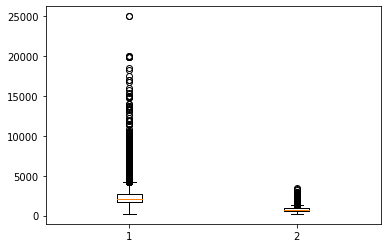

In [37]:
plt.boxplot(chicago_df[['price', 'sqft']])
plt.show()

In [38]:
def find_outliers(df: pd.DataFrame) -> pd.DataFrame:
    """Find rows containing outliers with IQR"""
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    return df[((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [39]:
def delete_rows(df: pd.DataFrame, to_delete: pd.DataFrame) -> pd.DataFrame:
    """Remove the subset of rows in to_delete from df and return
     the resulting dataframe
    """
    #df = df.copy()
    
    return df.drop(to_delete.index)

In [40]:
chicago_df = delete_rows(chicago_df, find_outliers(chicago_df[['price', 'sqft']]))

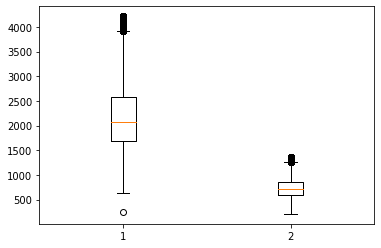

In [41]:
plt.boxplot(chicago_df[['price', 'sqft']])
plt.show()

**Calculating Average Price neighborhood_name**

In [42]:
chicago_df['average_price_by_neighborhood'] = chicago_df.groupby(['neighborhood_name', 
                                                                  'beds'])['price'].transform('mean')

**Handling Missing Values**

In [43]:
chicago_df.isna().sum()

index                               0
building_id                         0
lat                                10
lng                                10
cooperate                           0
neighborhood_name                 278
washer_dryer                        0
parking                             0
short_term_lease                    0
tour_sunday                         0
year_built                       5860
age                              5889
pool                                0
id                                  0
beds                                0
baths                               0
sqft                                0
price                               0
net_price                        6321
unit_balcony                        0
concession_unit                     0
average_price_by_neighborhood     278
dtype: int64

Dropping null neighborhood name because if predicted will cause biasness

In [44]:
chicago_df = chicago_df[chicago_df.neighborhood_name.notnull()]

In [45]:
chicago_df = chicago_df[chicago_df.average_price_by_neighborhood.notnull()]

In [46]:
chicago_df.isna().sum()

index                               0
building_id                         0
lat                                 0
lng                                 0
cooperate                           0
neighborhood_name                   0
washer_dryer                        0
parking                             0
short_term_lease                    0
tour_sunday                         0
year_built                       5708
age                              5737
pool                                0
id                                  0
beds                                0
baths                               0
sqft                                0
price                               0
net_price                        6249
unit_balcony                        0
concession_unit                     0
average_price_by_neighborhood       0
dtype: int64

In [47]:
chicago_df.shape

(40419, 22)

In [48]:
chicago_df.dtypes

index                              int64
building_id                        int64
lat                              float64
lng                              float64
cooperate                          int64
neighborhood_name                 object
washer_dryer                       int64
parking                            int64
short_term_lease                   int64
tour_sunday                        int64
year_built                        object
age                              float64
pool                               int64
id                                 int64
beds                               int64
baths                              int64
sqft                             float64
price                            float64
net_price                        float64
unit_balcony                       int64
concession_unit                  float64
average_price_by_neighborhood    float64
dtype: object

**Sqft Normalization**

In [49]:
import pandas as pd
from sklearn import preprocessing

x = chicago_df[['sqft']].values


In [50]:
min_max_scaler = preprocessing.MinMaxScaler()

In [51]:
x_scaled = min_max_scaler.fit_transform(x)

In [52]:
chicago_df['sqft_normalized'] = pd.DataFrame(x_scaled)

**Sqft scaling**

In [53]:
min_sqft = chicago_df[['sqft']].min()

In [54]:
max_sqft = chicago_df[['sqft']].max()

In [55]:
temp = chicago_df[['sqft']]

In [56]:
temp -= min_sqft

In [57]:
temp /= max_sqft


In [58]:
chicago_df['sqft_scaled'] = temp

**Sqft binning**

In [59]:
chicago_df['sqft'].max()

1365.0

In [60]:
sqft_dict = {'200-300': 1,
             '301-400': 2,
             '401-500': 3,
             '501-600': 4,
             '601-700': 5,
             '701-800': 6,
             '801-900' : 7,
             '901-1000': 8,
             '1001-1100': 9,
             '1101-1200': 10,
             '1201-1300':11,
             '1301-1400':12}

In [61]:
cut_labels_5= [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
cut_bins = [200, 300, 400, 500, 600, 700, 800, 900, 1000,1100, 1200, 1300,1400]
chicago_df['sqft_ranges'] = pd.cut(chicago_df['sqft'], bins=cut_bins, labels=cut_labels_5)

In [62]:
chicago_df['sqft_ranges'] = chicago_df['sqft_ranges'].astype(int)

In [63]:
chicago_df.head()

,index,building_id,lat,lng,cooperate,neighborhood_name,washer_dryer,parking,short_term_lease,tour_sunday,...,baths,sqft,price,net_price,unit_balcony,concession_unit,average_price_by_neighborhood,sqft_normalized,sqft_scaled,sqft_ranges
0,0,216,41.889181,-87.618089,1,Streeterville,0,0,0,0,...,1,661.0,1842.0,NaN,0,0.0,2287.550000,0.391530,0.331868,5
1,1,216,41.889181,-87.618089,1,Streeterville,0,0,0,0,...,1,854.0,2071.0,NaN,0,0.0,2287.550000,0.558341,0.473260,7
2,2,216,41.889181,-87.618089,1,Streeterville,0,0,0,0,...,1,500.0,1647.0,NaN,0,0.0,1674.873188,0.252377,0.213919,3
3,3,216,41.889181,-87.618089,1,Streeterville,0,0,0,0,...,2,1127.0,3045.0,3045.0,0,0.0,3196.539326,0.794296,0.673260,10
4,4,216,41.889181,-87.618089,1,Streeterville,0,0,0,0,...,1,500.0,1620.0,1620.0,0,0.0,1674.873188,0.252377,0.213919,3


In [64]:
selected_features = ['id',
                     'beds',
                     'baths', 
                     'washer_dryer',
                     'average_price_by_neighborhood',
                     'neighborhood_name',
                     'parking',
                     'sqft', 
                     'price',
                     'unit_balcony',
                     'pool',
                     'sqft_normalized',
                     'sqft_scaled',
                     'sqft_ranges',
                     
                                          
                    ]

In [65]:
chicago_df = chicago_df[selected_features]

In [66]:
chicago_df.head()

,id,beds,baths,washer_dryer,average_price_by_neighborhood,neighborhood_name,parking,sqft,price,unit_balcony,pool,sqft_normalized,sqft_scaled,sqft_ranges
0,189670,1,1,0,2287.550000,Streeterville,0,661.0,1842.0,0,1,0.391530,0.331868,5
1,189673,1,1,0,2287.550000,Streeterville,0,854.0,2071.0,0,1,0.558341,0.473260,7
2,189668,0,1,0,1674.873188,Streeterville,0,500.0,1647.0,0,1,0.252377,0.213919,3
3,288131,2,2,0,3196.539326,Streeterville,0,1127.0,3045.0,0,1,0.794296,0.673260,10
4,189669,0,1,0,1674.873188,Streeterville,0,500.0,1620.0,0,1,0.252377,0.213919,3


In [67]:
chicago_df.to_csv('data_with_id_and_neigbhorhood_name.csv', index=False)

In [68]:
unit_id = chicago_df.id.tolist()

**Pricing History Data Pre-processing**

In [69]:
building_price_history_df.shape

(3924626, 4)

In [70]:
building_price_history_df.isna().sum()

id                      0
price              269271
available_date    3573698
created_on              0
dtype: int64

In [71]:
price_history_df = building_price_history_df.loc[(building_price_history_df['id'].isin(unit_id))]

In [72]:
price_history_df.shape

(563224, 4)

In [73]:
price_history_df.drop(columns=['available_date'], inplace=True)

/home/maria/.local/lib/python3.9/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [74]:
price_history_df = price_history_df[price_history_df.price.notnull()]

In [75]:
price_history_df.isna().sum()

id            0
price         0
created_on    0
dtype: int64

In [76]:
price_history_df.shape

(525294, 3)

In [77]:
price_history_df = price_history_df.drop(price_history_df.loc[price_history_df['price'] <=100].index)

In [78]:
price_history_df.shape

(522226, 3)

In [79]:
price_history_df.to_csv('price_history_chicago_data.csv', index=False)